In [2]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools

comment = "Generate core and sat, load saved realizations and plot"

import pickle

In [6]:
core = SDSS(comment, N_SH = 60, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = 40, r_at = core.r_cmb)

grid_in = np.array([core.grid_glq_phi, 90-core.grid_glq_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

core.generate_map()

#core.condtab(normsize=10000)
core.semivar(model_lags = 24, model = "exponential", max_dist = 7000, lag_length = 50, zero_nugget = True)

____semi-variogram setup___

Number of data used: 7656525
Max data distance: 6999.763 km
Lag length chosen: 50.0 km
Number of lags: 139
Number of modelling lags: 24

Semi-variogram model determined, starting LUT computation



In [61]:
s_sat = SDSS(comment, N_SH = 60, sim_type = "sat", sat_height = 350)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.swarm_phi, 90-s_sat.swarm_theta]).T
s_sat.make_grid(s_sat.swarm_radius, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")


Gauss-Legendre RMSE:	 0.555


<IPython.core.display.Javascript object>


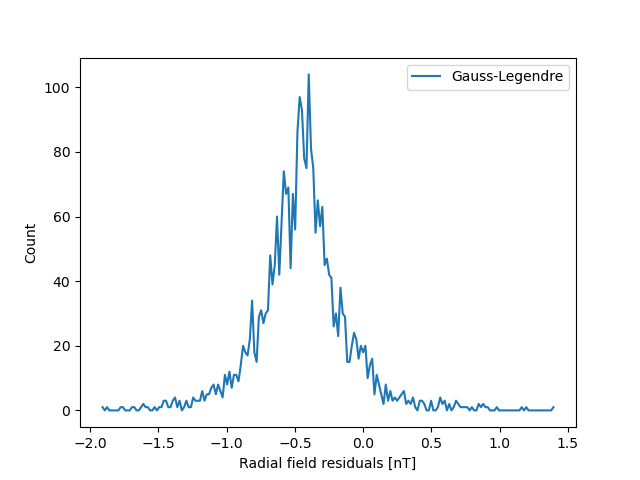

(2773, 3321)
(2773, 3321)
(2773, 2773)


In [8]:
G_r = mt_util.Gr_vec(core.r_grid, s_sat.r_grid, core.lat, s_sat.lat, core.lon, s_sat.lon)
G_d = np.pi/(core.grid_glq_nmax+0.5)*np.multiply(core.grid_glq_w,G_r) # +0.5 for parity with SHTOOLS

errorstd = 3
errorvar = errorstd**2

def covmod_lsq_equiv(obs,semivar,target_var,G_d,title="",errorvar = 10e2):
    a_0 = np.empty([0,])
    b_0 = obs
    d_0 = b_0

    G = G_d.copy()
    C_M = target_var - semivar
    C_D = np.zeros((len(a_0)+len(b_0),len(a_0)+len(b_0)))
    C_D[np.arange(len(a_0)+1,len(a_0)+len(b_0)),np.arange(len(a_0)+1,len(a_0)+len(b_0))] = errorvar
    S = C_D + G*C_M*G.T
    T = np.linalg.inv(S)
    m_equiv_lsq = C_M*G.T*T*d_0
    lsq_equiv_pred = G_d*m_equiv_lsq
    lsq_equiv_res = obs - lsq_equiv_pred
    return m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res

m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res = covmod_lsq_equiv(s_sat.data.reshape(-1,1),core.sv_lut,core.target_var,G_d,title="Gauss-Legendre equivalent LSQ solution",errorvar = errorvar)

# RMSE
rmse_leg = np.sqrt(np.mean(np.power(lsq_equiv_res,2)))
print("")
print("Gauss-Legendre RMSE:\t %0.3f" %rmse_leg)
plt.figure()
y,binEdges=np.histogram(lsq_equiv_res,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'C0',label="Gauss-Legendre")
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.legend()
plt.show()

#%% GREENS CORE
print(G_d.shape)
G_k = G_d*(core.target_var-core.sv_lut)
print(G_k.shape)
GG_K = G_k*G_d.T  + np.diag(errorvar*np.ones(s_sat.swarm_N,))
print(GG_K.shape)
sort_support = np.flipud(np.argsort(G_k,axis=0))
idx_data_support = sort_support

In [104]:
core.zs = np.load("zs_nb_sh_core_swarm_A_sh40_chosolve_z99.npy")
core.zs = core.zs[:,:100]

In [105]:
core.zs.shape

(3321, 100)

In [106]:
core.zs[:,-1]

array([-256330.94897942,  -77572.22463314, -111897.04219035, ...,
        -27330.11173295,     552.09753089, -160442.95212836])

In [107]:
N_sim = core.zs.shape[1]


Seqsim RMSE:	 [[0.95648018 1.02600218 0.98474474 0.98735973 0.9426225  1.01273466
  0.98676131 0.99721854 0.95897829 0.99710431 0.99808246 1.14953762
  0.95445658 0.97578259 0.96961684 0.98536696 1.04692214 0.92270609
  0.99628282 1.01790745 0.97987152 0.97687702 1.02613379 0.94420511
  0.91946041 0.98642241 0.98642767 1.02853989 0.98839841 1.00711912
  1.03827675 0.98853725 1.07194925 1.00176745 0.97554508 0.92611171
  0.94495388 1.03242218 1.08558897 0.97575544 1.05014609 0.96717921
  0.93782865 0.98791112 0.97993642 0.97425957 0.93118275 0.96762149
  1.0584414  1.05265826 0.97419338 0.97651035 1.02626274 0.9455164
  0.93936549 0.97590007 1.08235048 1.01073535 0.99947428 1.05390546
  1.00842573 1.06781508 1.02609292 0.96798245 0.92552324 0.94051366
  0.95655792 0.94065832 0.92613991 0.9908999  0.94039185 0.88669154
  1.05359355 0.97153296 0.97846547 0.93815497 0.96016367 0.97567212
  0.9879778  0.92526892 0.99932232 1.04137198 0.99557822 0.97551894
  1.01522027 0.95811466 0.9409213 

<IPython.core.display.Javascript object>


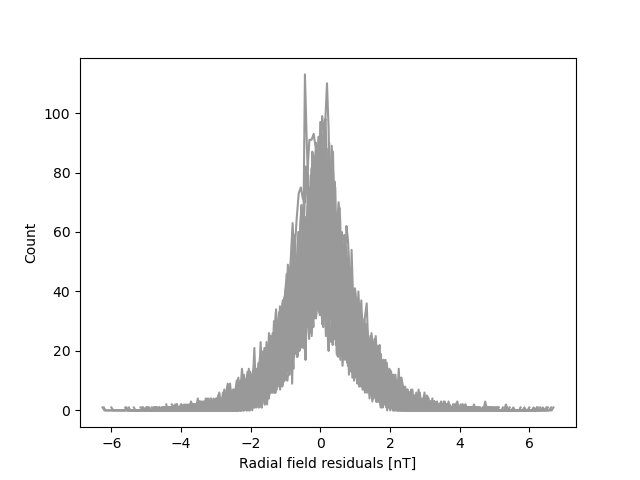

In [108]:
seqsim_pred = G_d*core.zs
seqsim_res = s_sat.data.reshape(-1,1) - seqsim_pred

rmse_leg = np.sqrt(np.mean(np.power(seqsim_res,2),axis=0))
print("")
print("Seqsim RMSE:\t {}".format(rmse_leg))

color_rgb = (0.6,0.6,0.6)
plt.figure()
for i in np.arange(0,N_sim):
    y,binEdges=np.histogram(seqsim_res[:,[i]],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    if i == 0:
        plt.plot(bincenters,y,'-',color = color_rgb,label='Seqsim')  
    else:
        plt.plot(bincenters,y,'-',color = color_rgb)  
        
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.show()

<IPython.core.display.Javascript object>


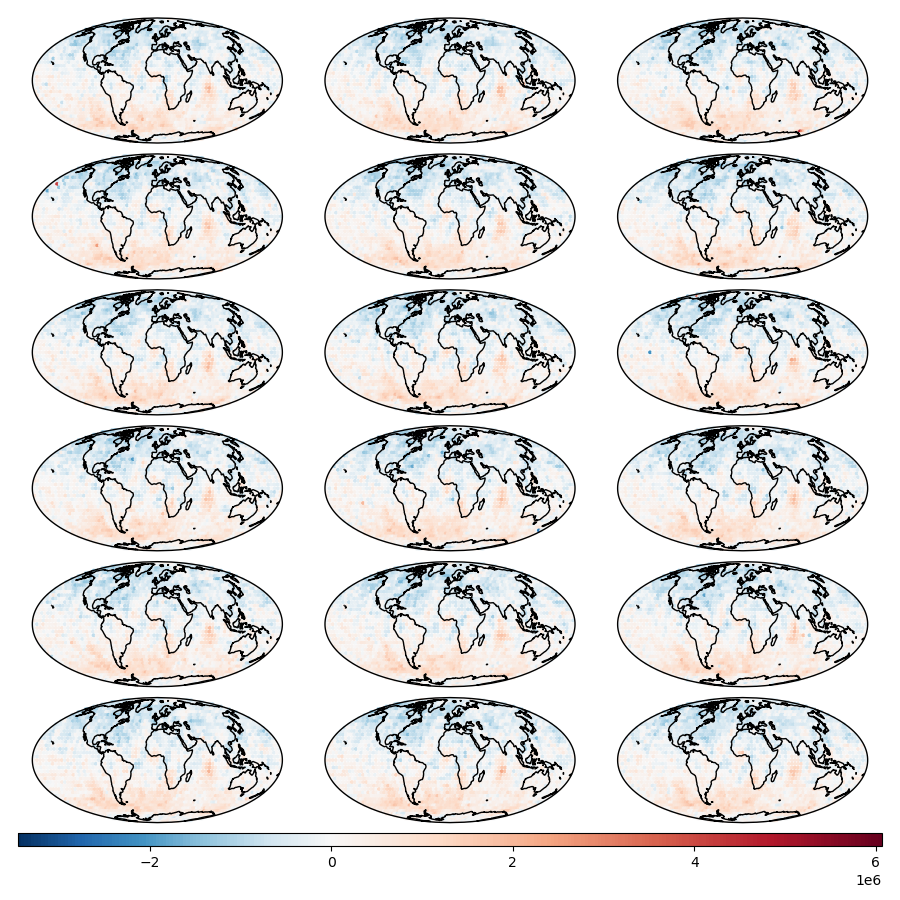

In [68]:
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.lon, core.lat, core.zs, tile_size_row = 6, tile_size_column = 3, 
                        figsize=(9,9), limit_for_SF = 10**6, shrink_factor = 1.0, point_size = 3,
                        left=0.02, bottom=0.06, right=0.98, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

<IPython.core.display.Javascript object>


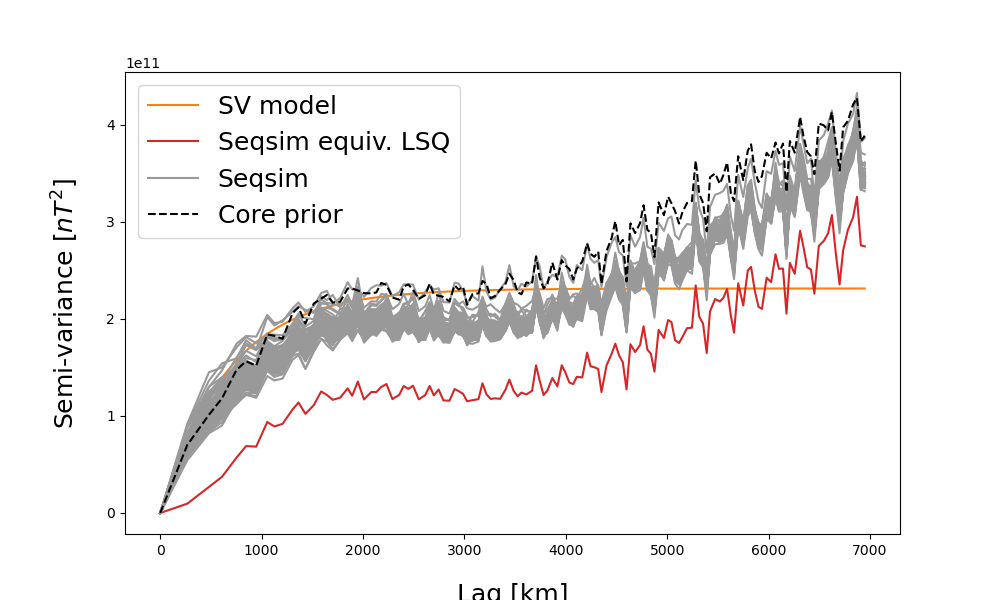

<IPython.core.display.Javascript object>


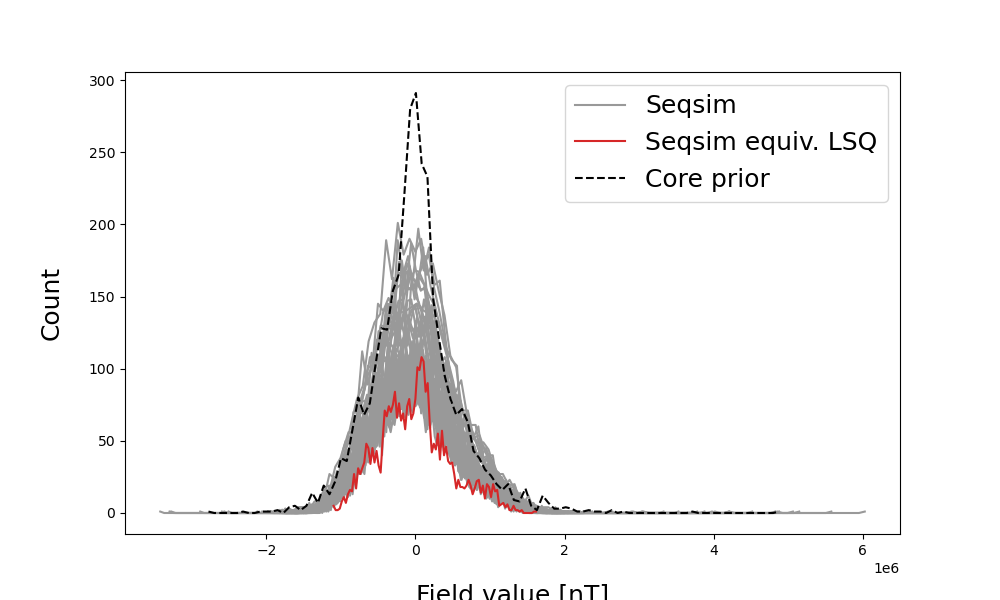

In [69]:
color_rgb = (0.6,0.6,0.6)

bins = 100

#% SEMI-VARIOGRAM
plt.figure(figsize=(10,6))

#plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')

plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',label='SV model')


core.sv_zs(core.grid_glq_N,1,np.array(m_equiv_lsq),core.sort_d,core.n_lags,core.max_cloud)
plt.plot(core.lags,core.pics_zs[:,0],color = 'C3',label='Seqsim equiv. LSQ')    

for i in np.arange(0,N_sim):
    core.sv_zs(core.grid_glq_N,1,core.zs[:,[i]],core.sort_d,core.n_lags,core.max_cloud)
    if i == 0:
        plt.plot(core.lags,core.pics_zs[:,0],color = color_rgb, label='Seqsim')
    else:
        plt.plot(core.lags,core.pics_zs[:,0],color = color_rgb) 
#print(zs[:,[0]].shape)
#print(core.pics_zs.shape)

#core.sv_zs(core.grid_glq_N,1,data_lstsq["data"].reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)
#plt.plot(core.lags,core.pics_zs[:,0],color = 'C4',label='LSQ')  

#plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='Core field estimate')

core.sv_zs(core.grid_glq_N,1,core.data.reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)
plt.plot(core.lags,core.pics_zs[:,0],'k--',label='Core prior') 

plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.legend(loc='best',fontsize=18)
plt.show()

#% HISTOGRAM
plt.figure(figsize=(10,6))     

for i in np.arange(0,N_sim):
    y,binEdges=np.histogram(core.zs[:,[i]],bins=bins,density=False)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    if i == 0:
        plt.plot(bincenters,y,'-',color = color_rgb,label='Seqsim')  
    else:
        plt.plot(bincenters,y,'-',color = color_rgb)   

#y,binEdges=np.histogram(data_lstsq["data"].reshape(-1,1),bins=50,density=False)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#plt.plot(bincenters,y,'-',color = 'C4',label='LSQ')    

y,binEdges=np.histogram(np.array(m_equiv_lsq),bins=bins,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = 'C3',label='Seqsim equiv. LSQ') 

y,binEdges=np.histogram(core.data,bins=bins,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'k--',label='Core prior')

plt.legend(loc='best',fontsize=18)
plt.xlabel('Field value %s' % "[nT]",fontsize=18,labelpad=18)
plt.ylabel('Count',fontsize=18,labelpad=18)
plt.show()

In [110]:
core.grid_glq(nmax = 40, r_at = core.r_cmb)

core.g_spec = []

for i in np.arange(0,N_sim):

    C_cilm = pyshtools.expand.SHExpandGLQ(core.zs[:,[i]].reshape(core.grid_glq_nmax+1,2*core.grid_glq_nmax+1), core.grid_glq_w_shtools, core.grid_glq_zero, [2, 1, core.grid_glq_nmax])
    nm_C = mt_util.array_nm(core.grid_glq_nmax)

    C_corr_sh = 1/(nm_C[:,[0]]+1)*1/(core.a/core.r_cmb)**(nm_C[:,[0]]+2)
    
    C_index = np.transpose(pyshtools.shio.SHCilmToCindex(C_cilm))
    C_index = C_index[1:,:]*C_corr_sh

    C_vec = mt_util.gauss_vector(C_index, core.grid_glq_nmax, i_n = 0, i_m = 1)
    
    core.g_spec.append(C_vec)

core.g_spec = np.array(core.g_spec).T
print(core.g_spec.shape)

(1680, 100)


In [111]:
core.g_spec[:3,:10]

array([[-51832.28495997, -51832.16806152, -51831.80648622,
        -51831.62310711, -51832.80503568, -51831.42031168,
        -51833.07466399, -51831.84624157, -51832.66411538,
        -51832.84091358],
       [  3138.69042629,   3138.79635216,   3138.74257283,
          3138.71862973,   3138.71644951,   3138.68397679,
          3138.58202215,   3138.66139343,   3138.71294353,
          3138.79083807],
       [   680.24570204,    680.333416  ,    680.31338618,
           680.29502277,    680.39642256,    680.24787102,
           680.25057777,    680.40832964,    680.35495723,
           680.15520867]])

In [112]:
core.g_prior[:3]

array([-51832.174  ,   3138.7632 ,    680.29256])

<IPython.core.display.Javascript object>


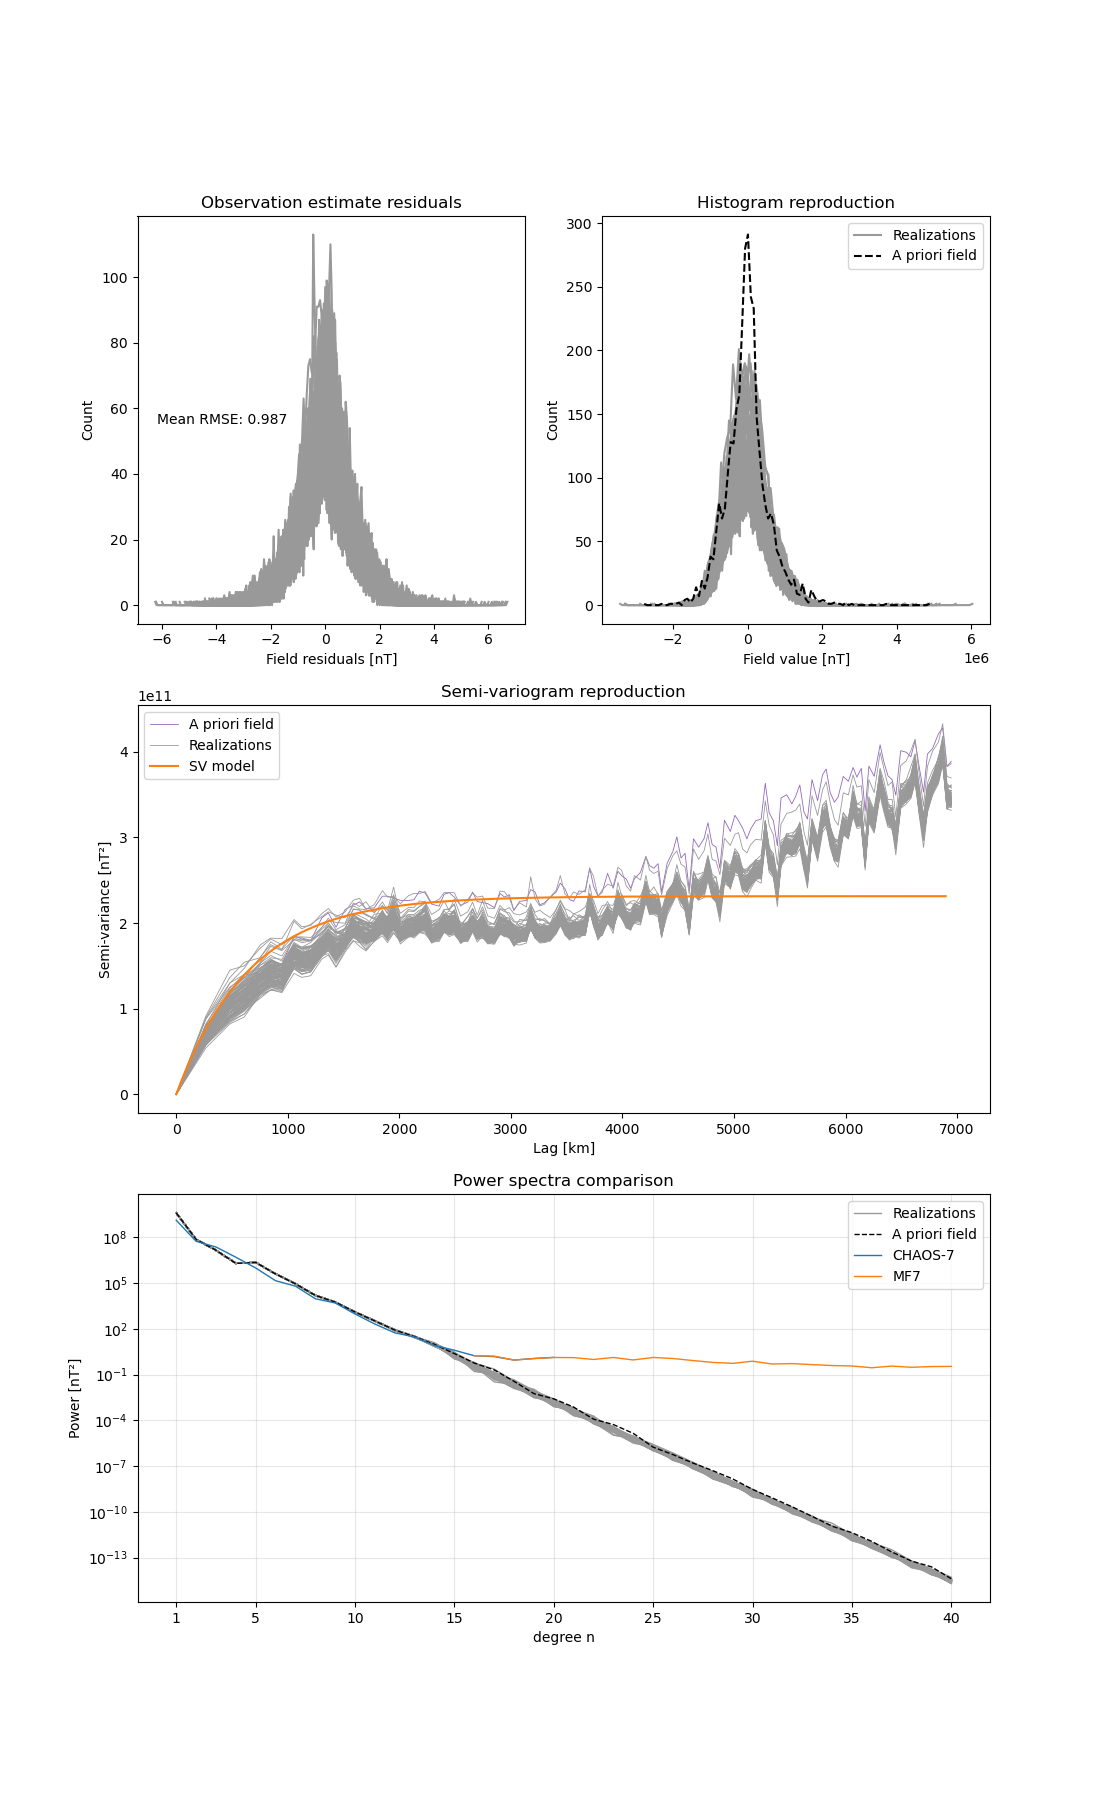

In [113]:
mt_util.plot_sdssim_reproduce(core, seqsim_res, lags_use = 1000, spec_r_at = core.r_sat,
                              model_dict = {"CHAOS-7", "MF7"}, figsize=(11,18),
                              savefig = False, save_string = "core_A_sh40")

In [114]:
core.grid_glq(nmax = 120, r_at = core.a)

core.ensemble_B(core.g_spec, nmax = 40, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble_glq[:,0,:].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(40)], nmax = 40, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble_glq[:,0].copy()

<IPython.core.display.Javascript object>


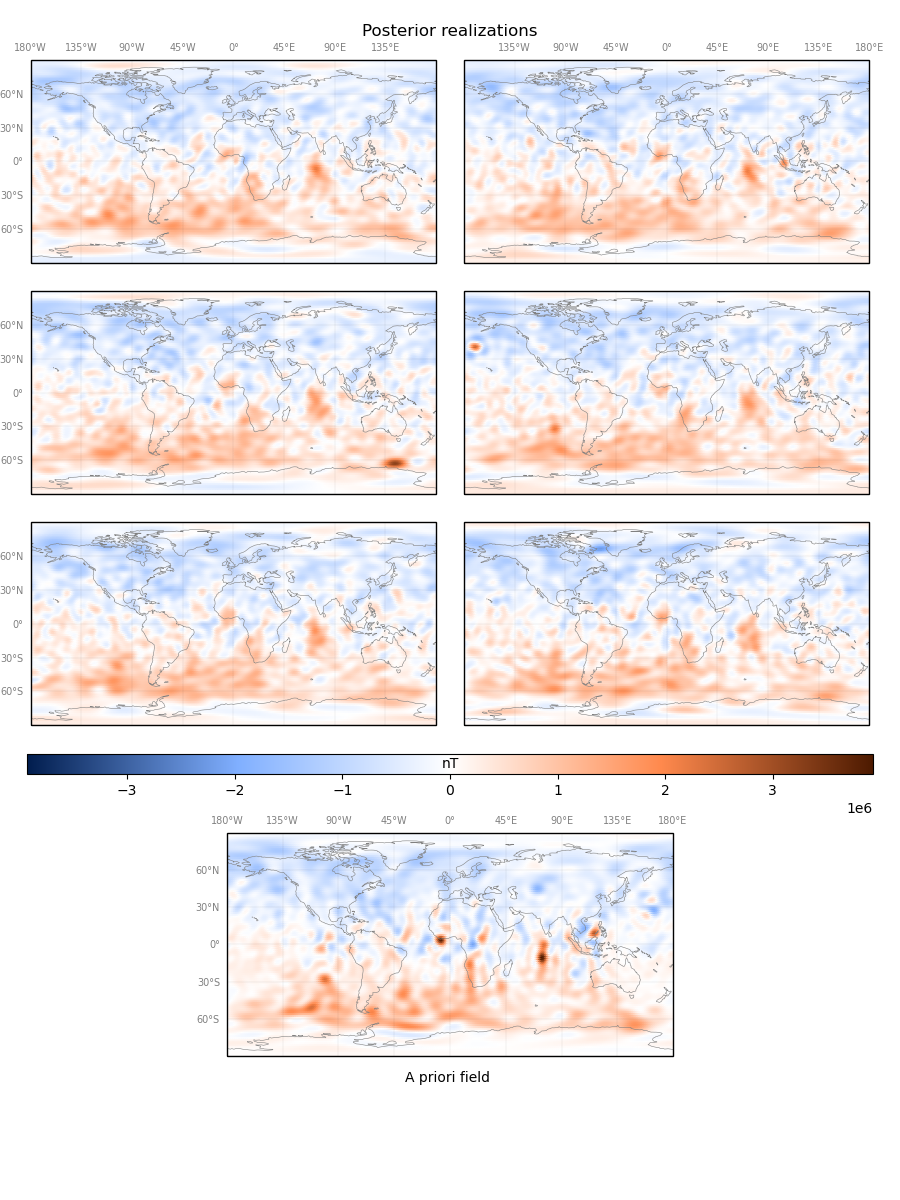

In [212]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

#mt_util.plot_ensemble_map_tiles(core.grid_eqa_phi, 90-core.grid_eqa_theta, zs_eqa, 
mt_util.plot_ensemble_map_tiles(core.grid_glq_phi, 90-core.grid_glq_theta, zs_eqa, 
                        field_compare = prior_eqa, tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10,
                        coast_width = 0.4, coast_color = "grey",
                        cbar_h = 0.1, cbar_text = "nT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "core_A_sh40", 
                        projection = ccrs.PlateCarree(), use_gridlines = True, 
                        gridlines_width = 0.2, gridlines_alpha = 0.2, save_dpi = 100)


#mt_util.plot_cartopy_global(lat = 90-core.grid_eqa_theta, lon = core.grid_eqa_phi, plot_quality = "high", 
#                            data=prior_eqa, limits_data = core.data, point_size=8, 
#                            scale_uneven = True, cmap = plt.cm.RdBu_r, figsize=(7,8), 
#                            title="Prior radial core information", norm_class = "midpoint")

<IPython.core.display.Javascript object>


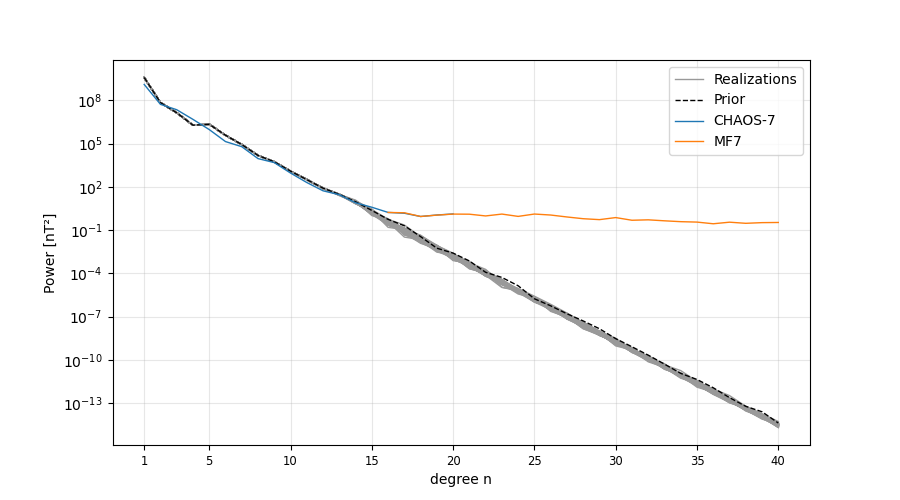

In [73]:
g_spec_compares = core.g_prior
model_dict = {"CHAOS-7", "MF7"}
labels = ["Realization"]

mt_util.plot_p_spec(core.g_spec, core.r_sat, core.grid_glq_nmax, spec_style = "ensemble",
                    g_spec_compares = g_spec_compares,
                    model_dict = model_dict, label = "Realizations", label_compare = "Prior",
                    lwidth = 1, lwidth_m = 1, figsize = (9,5), color = (0.6, 0.6, 0.6))

In [3]:
core.grid_equal_area(N_grid = 15020, r_at = core.r_cmb, poles_remove = True)

core.ensemble_B(core.g_spec, nmax = core.grid_glq_nmax, r_at = core.r_cmb, grid_type = "eqa")

zs_eqa = core.B_ensemble_eqa[:,0,:].copy()

# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_eqa_phi, 90-core.grid_eqa_theta, zs_eqa, 
                        field_compare = core.data, tile_size_row = 27, tile_size_column = 3, 
                        figsize=(9,55), limit_for_SF = 10**6, shrink_factor = 1.0, point_size = 3,
                        left=0.02, bottom=0.26, right=0.97, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

core.ensemble_B(g_spec_compares[:mt_util.shc_vec_len(core.grid_glq_nmax)], nmax = core.grid_glq_nmax, r_at = core.r_cmb, grid_type = "eqa")

prior_eqa = core.B_ensemble_eqa[:,0].copy()

mt_util.plot_cartopy_global(lat = 90-core.grid_eqa_theta, lon = core.grid_eqa_phi, plot_quality = "high", 
                            data=prior_eqa, limits_data = core.data, point_size=10, 
                            scale_uneven = True, cmap = plt.cm.RdBu_r, figsize=(5,5), 
                            title="Prior radial core information", norm_class = "midpoint")

NameError: name 'core' is not defined

In [86]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

<module 'mikkel_tools.utility' from '/home/mikotz/spherical_direct_sequential_simulation/mikkel_tools/utility.py'>

In [38]:
#mt_util.plot_cartopy_animation(lat = 90-core.grid_eqa_theta, lon = core.grid_eqa_phi, limits_data = core.B_ensemble_eqa[:,0,0], data=core.B_ensemble_eqa[:,0,:], animation_quality = "high", frames = 99, interval = 24, point_size = 10)

In [2]:
diff_to_prior = zs_eqa-prior_eqa.reshape(-1,1)

mt_util.plot_ensemble_map_tiles(core.grid_eqa_phi, 90-core.grid_eqa_theta, diff_to_prior, 
                        field_compare = core.data, tile_size_row = 27, tile_size_column = 3, 
                        figsize=(9,55), limit_for_SF = 10**6, shrink_factor = 1.0, point_size = 3,
                        left=0.02, bottom=0.26, right=0.97, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

NameError: name 'zs_eqa' is not defined

In [1]:
diff_to_mean = zs_eqa-np.mean(zs_eqa,axis=1).reshape(-1,1)

mt_util.plot_ensemble_map_tiles(core.grid_eqa_phi, 90-core.grid_eqa_theta, diff_to_mean, 
                        tile_size_row = 27, tile_size_column = 3, 
                        figsize=(9,55), limit_for_SF = 10**6, shrink_factor = 1.0, point_size = 3,
                        left=0.02, bottom=0.26, right=0.97, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

NameError: name 'zs_eqa' is not defined

In [85]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Generate core and sat, load saved realizations and plot
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  60
sim_type:              core
grid_glq_zero:         (41,), Max/Min: 1.00 / -1.00
grid_glq_w_shtools:    (41,), Max/Min: 0.08 / 0.00
grid_glq_shape:        (2,), Max/Min: 81.00 / 41.00
grid_glq_w:            (3321,), Max/Min: 0.08 / 0.00
grid_glq_radial:       (3321,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (3321,), Max/Min: 176.68 / 3.32
grid_glq_phi:          (3321,), Max/Min: 355.56 / 0.00
grid_glq_N:            3321
grid_glq_nmax:         40
r_grid:                3480.0
grid:                  (3321, 2)
sph_d:                 (3321, 3321)
lon:                   (3321,), Max/Min: 355.56 /